In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import scipy.integrate as integrate
import GPy

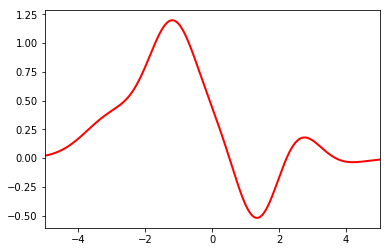

In [2]:
def sample_function(x_range, N=1000, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = GPy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
#     mean = gpy.mappings.Linear(dx, 1)
    mu = np.zeros(x.shape)
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    #import pdb; pdb.set_trace()
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.01

    def f(x): return m.predict(x)[0]
    return f
x_range = np.array([[-2.], [2.]])
f = sample_function(x_range)

def plot_f(f):
    xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
    yy = f(xx)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(-5.0, 5.0)
    plt.show()
plot_f(f)

def plot(m, reff=None):
    xx = np.linspace(-5.0, 5.0, 300).reshape(300, 1)
    mean, std = m.predict(xx,return_std=True)
    mean = mean[:,0]
    plt.plot(xx, mean, 'r', lw=2,label='GP mean')
    plt.fill_between(xx[:, 0],
                     mean - std**2,
                     mean + std**2,
                     color='r', alpha=0.2,label='95% confidence interval')
    plt.xlim(-5.0, 5.0)
    if reff:
        xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
        yy = reff(xx)
        plt.plot(xx, yy, 'b', lw=2,label='ground truth')
        plt.xlim(-5.0, 5.0)
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(3.0)).pdf(s)
print f(np.array([[0]]))
print "Mean Numerical Integration"
integral_value,_ = integrate.quad(lambda x: f(np.array([[x]]))*normal(x),np.NINF,np.inf)
print integral_value

[[0.43797356]]
Mean Numerical Integration
0.354323036495


In [4]:
def bintegrate(gp,b,B):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = (z.T).dot(cho_solve((gp.L_, True), gp.y_train_))
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, cho_solve((gp.L_, True), z))
    return mean[0][0], var[0][0], z

def bacquistion(gp,xs,zprev):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    
    for i in range(xs.shape[0]):
        x = xs[i, :]
        Xnew = np.vstack((gp.X_train_, x))
        K = gp.kernel_(Xnew)
        K[np.diag_indices_from(K)] += gp.alpha
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((zprev, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[0]]

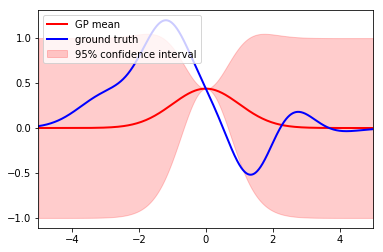

Mean: 0.2189867795883367 , Variance 0.1279644730342273
new sample[[1.86868687]]


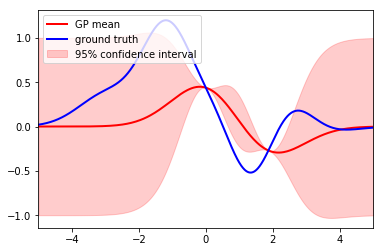

Mean: 0.1346823587147430 , Variance 0.0705626767135828
new sample[[-1.76767677]]


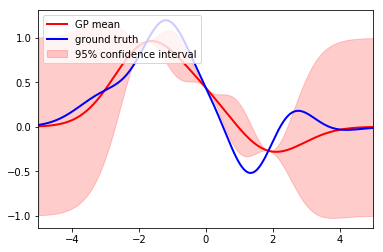

Mean: 0.3507937949162032 , Variance 0.0091833621838640
new sample[[-3.48484848]]


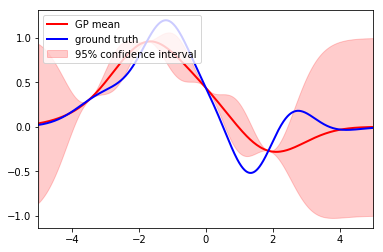

Mean: 0.3561408601380298 , Variance 0.0064751268874093
new sample[[3.68686869]]


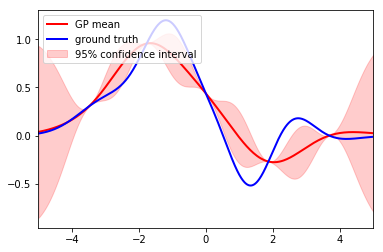

Mean: 0.3588708272656441 , Variance 0.0045806924961227
new sample[[1.26262626]]


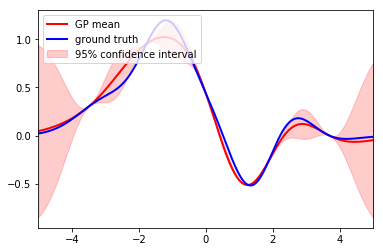

Mean: 0.3218447722496729 , Variance 0.0027616469107452
new sample[[-0.95959596]]


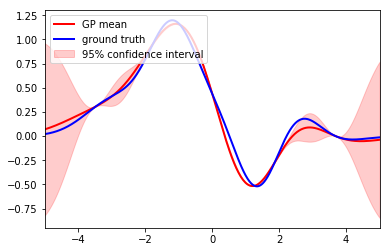

Mean: 0.3363688644486135 , Variance 0.0010895463472394
new sample[[2.27272727]]


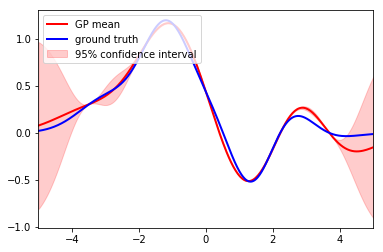

Mean: 0.3494687366742784 , Variance 0.0003690952345221
new sample[[-2.47474747]]


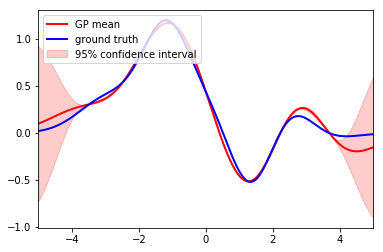

Mean: 0.3480313742220121 , Variance 0.0000714069676862
new sample[[-4.8989899]]


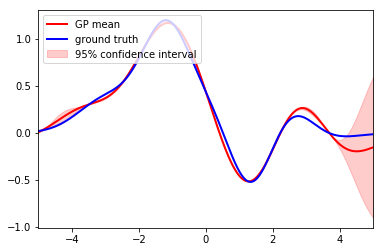

Mean: 0.3474528466971794 , Variance 0.0000370837243255
new sample[[0.45454545]]


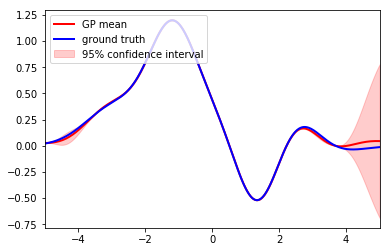

Mean: 0.3541451624501502 , Variance 0.0000172030420044
new sample[[5.]]


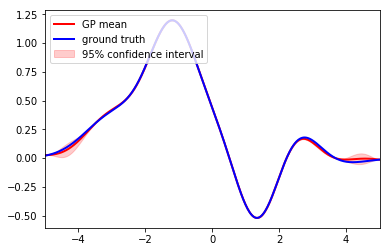

Mean: 0.3539071125533786 , Variance 0.0000046926199422
new sample[[3.18181818]]


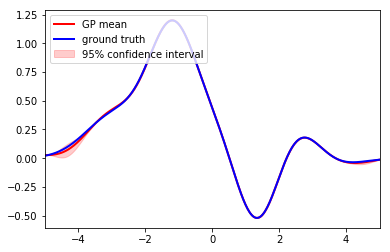

Mean: 0.3542503577685086 , Variance 0.0000013846471495
new sample[[-3.98989899]]


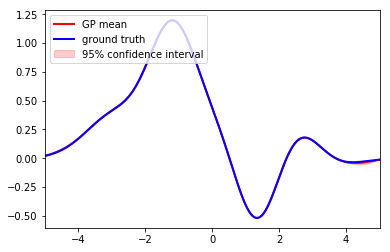

Mean: 0.3543479481617069 , Variance 0.0000008411533339
new sample[[-0.05050505]]


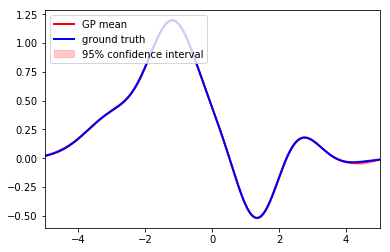

Mean: 0.3543364958932180 , Variance 0.0000006471955759
new sample[[3.58585859]]


 /Library/Python/2.7/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


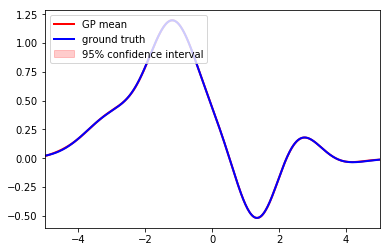

Mean: 0.3543805997967144 , Variance 0.0000004662532987
new sample[[-2.17171717]]


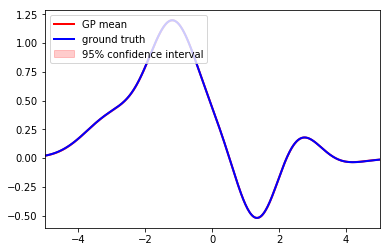

Mean: 0.3543193607160502 , Variance 0.0000003013515082
new sample[[-5.]]


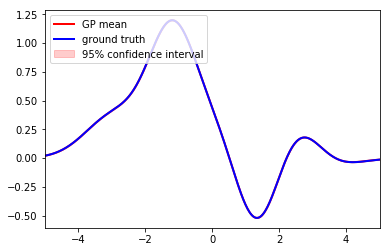

Mean: 0.3543130361343287 , Variance 0.0000002296562081
new sample[[-4.7979798]]


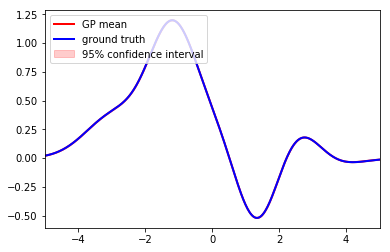

Mean: 0.3543208989116104 , Variance 0.0000001343068641
new sample[[4.8989899]]


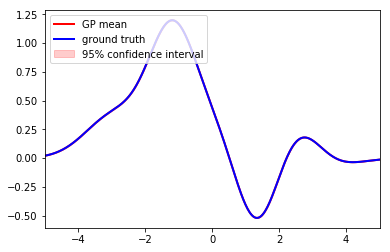

Mean: 0.3543264231304448 , Variance 0.0000000797092224
new sample[[4.7979798]]


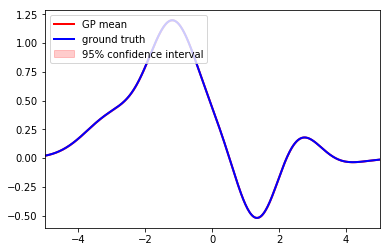

Mean: 0.3543216127677056 , Variance 0.0000000362892888
new sample[[4.5959596]]


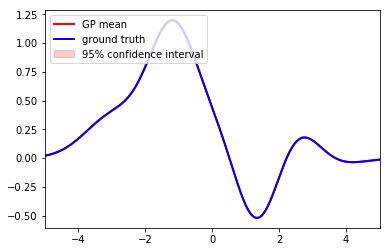

Mean: 0.3543240296755208 , Variance 0.0000000238477296
new sample[[-4.6969697]]


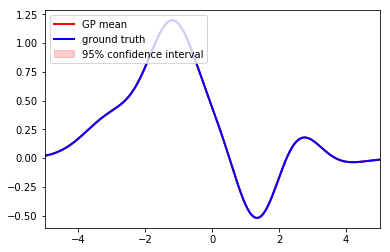

Mean: 0.3543226593181430 , Variance 0.0000000175976604
new sample[[-3.58585859]]


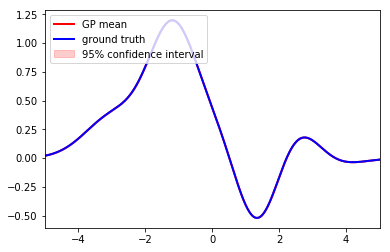

Mean: 0.3543236543987831 , Variance 0.0000000149440786
new sample[[3.98989899]]


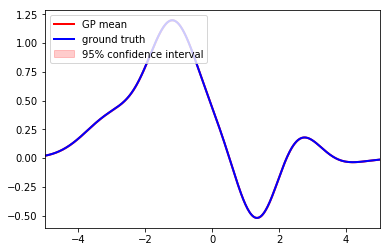

Mean: 0.3543231018799409 , Variance 0.0000000131479675
new sample[[-4.5959596]]


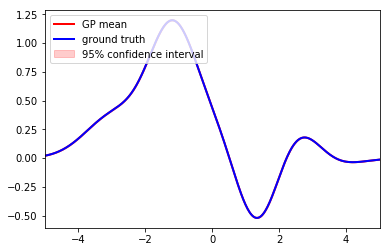

Mean: 0.3543232622285615 , Variance 0.0000000121252818
new sample[[-2.77777778]]


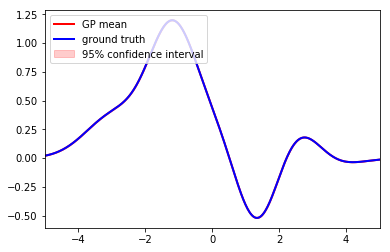

Mean: 0.3543229998789883 , Variance 0.0000000116645847
new sample[[4.8989899]]


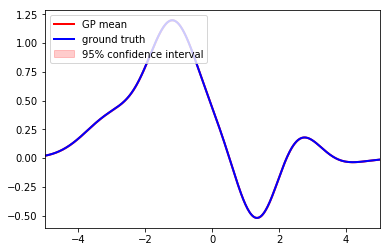

Mean: 0.3543229834349404 , Variance 0.0000000114039506
new sample[[4.7979798]]


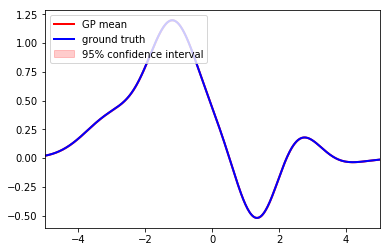

Mean: 0.3543229637077050 , Variance 0.0000000111360812
new sample[[-0.25252525]]


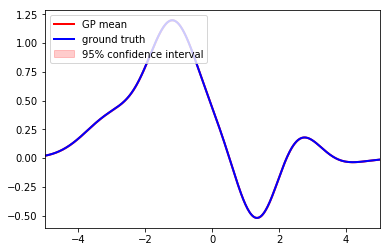

Mean: 0.3543230333424106 , Variance 0.0000000108771092
[(0.13533625690625672, 0.12796447303422726), (0.2196406777798504, 0.0705626767135828), (0.003529241578390241, 0.009183362183864008), (0.0018178236434364115, 0.00647512688740931), (0.004547790771050664, 0.004580692496122696), (0.03247826424492051, 0.002761646910745208), (0.017954172045979877, 0.0010895463472394007), (0.0048542998203150445, 0.0003690952345221099), (0.0062916622725812665, 7.140696768620503e-05), (0.00687018979741405, 3.7083724325537304e-05), (0.00017787404444324917, 1.720304200436562e-05), (0.000415923941214813, 4.6926199421815085e-06), (7.26787260848516e-05, 1.384647149549334e-06), (2.491166711349191e-05, 8.411533338748001e-07), (1.345939862462675e-05, 6.471955758535763e-07), (5.756330212103311e-05, 4.662532987476098e-07), (3.6757785432106616e-06, 3.0135150824728285e-07), (1.0000360264661445e-05, 2.2965620805059928e-07), (2.137582982952857e-06, 1.3430686407467363e-07), (3.3866358514211825e-06, 7.970922238920153e-08),

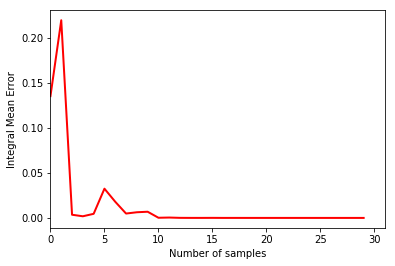

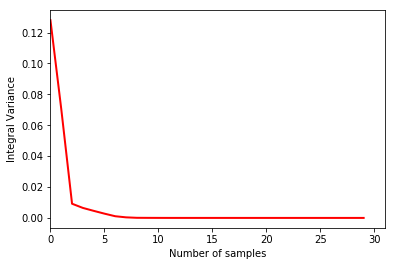

In [5]:
# WITH BAYESIAN QUADRATURE

yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    if i>0:
        xs = np.atleast_2d(np.linspace(-5,5,100)).T
        newx = bacquistion(gp,xs,zprev).reshape((1,-1))
        print "new sample" + str(newx)
        x = np.vstack((x, newx))
        y = f(x)
    else:
        x = np.atleast_2d(np.linspace(0,0,1)).T
        y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')

ITERATION: 0


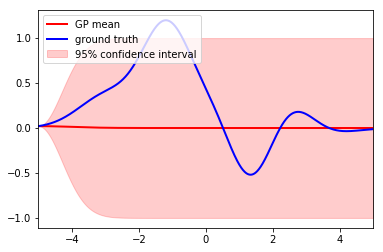

Mean: 0.0004584152780776 , Variance 0.3774818594752186
ITERATION: 1


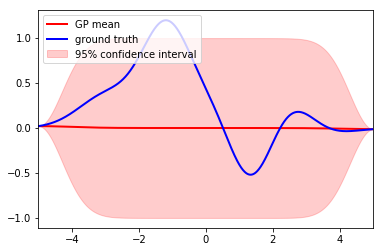

Mean: 0.0001774087483784 , Variance 0.3769992459412099
ITERATION: 2


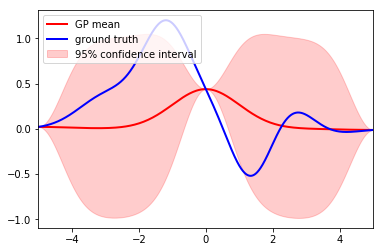

Mean: 0.2191641015825160 , Variance 0.1269994096969521
ITERATION: 3


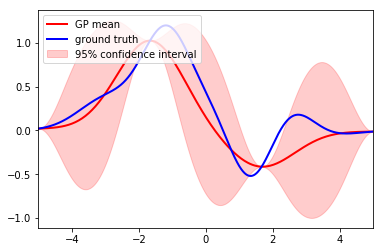

Mean: 0.2153292017315707 , Variance 0.1284007128616954
ITERATION: 4


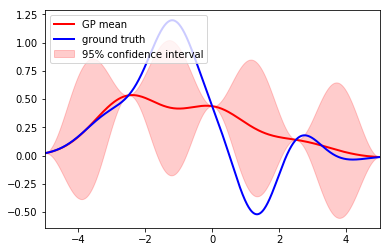

Mean: 0.3506464678874497 , Variance 0.0416473703921365
ITERATION: 5


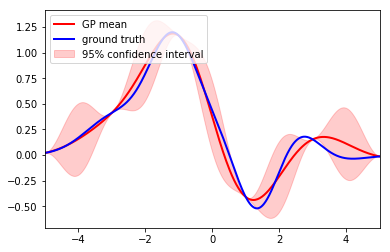

Mean: 0.3469607716079845 , Variance 0.0104692326227099
ITERATION: 6


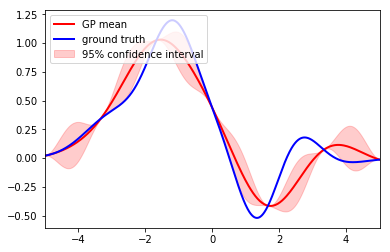

Mean: 0.3396669298140410 , Variance 0.0016823711313458
ITERATION: 7


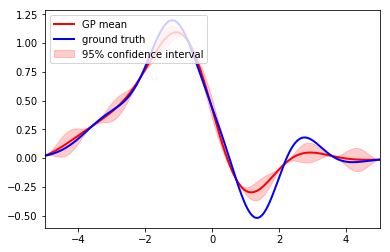

Mean: 0.3613916501239169 , Variance 0.0001891496287459
ITERATION: 8


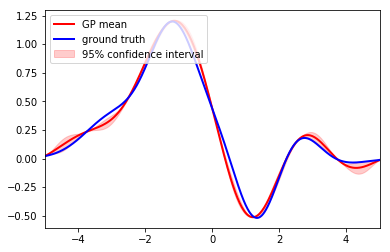

Mean: 0.3525307601764913 , Variance 0.0000152707084076
ITERATION: 9


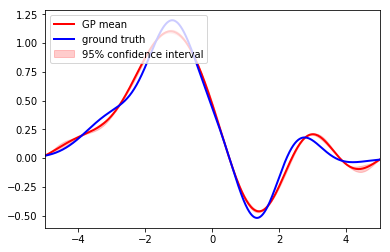

Mean: 0.3545954460516284 , Variance 0.0000012126527427
ITERATION: 10


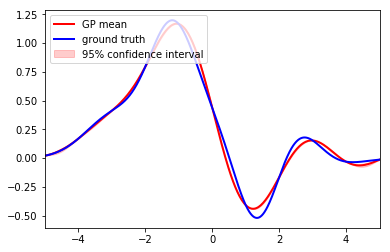

Mean: 0.3543365593464086 , Variance 0.0000004449550693
ITERATION: 11


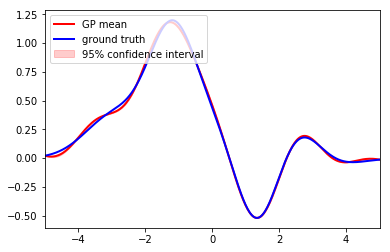

Mean: 0.3543462756540734 , Variance 0.0000004290671043
ITERATION: 12


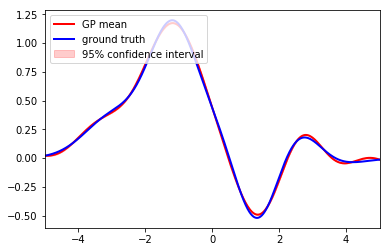

Mean: 0.3542831069741760 , Variance 0.0000004146981718
ITERATION: 13


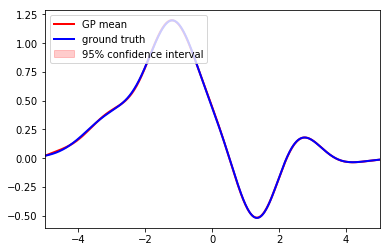

Mean: 0.3542752043556047 , Variance 0.0000003944812194
ITERATION: 14


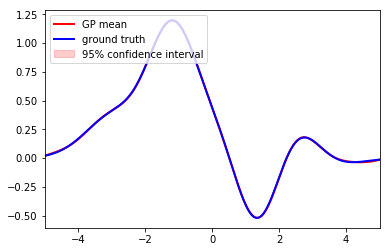

Mean: 0.3543390177201974 , Variance 0.0000003507659871
ITERATION: 15


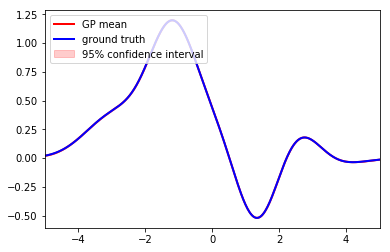

Mean: 0.3543523478194572 , Variance 0.0000003185263208
ITERATION: 16


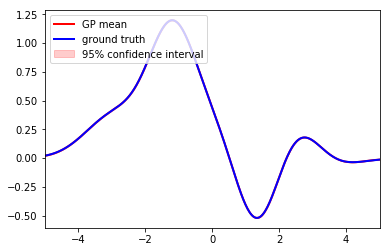

Mean: 0.3543205337076824 , Variance 0.0000002668746811
ITERATION: 17


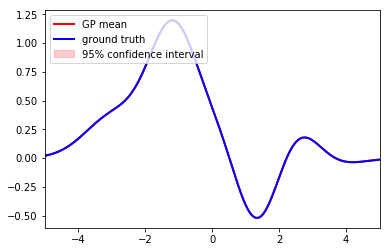

Mean: 0.3543138940788131 , Variance 0.0000002366269510
ITERATION: 18


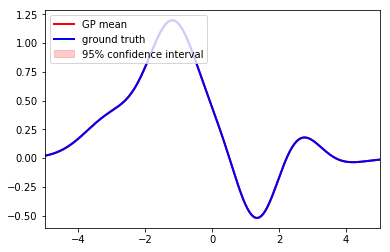

Mean: 0.3543228914354700 , Variance 0.0000001894794241
ITERATION: 19


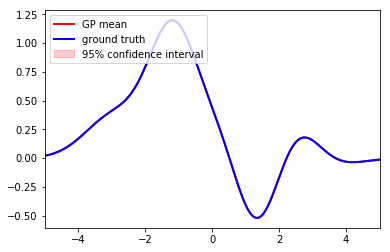

Mean: 0.3543246373423217 , Variance 0.0000001660736825
ITERATION: 20


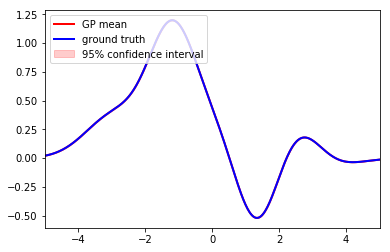

Mean: 0.3543231627223533 , Variance 0.0000001282373430
ITERATION: 21


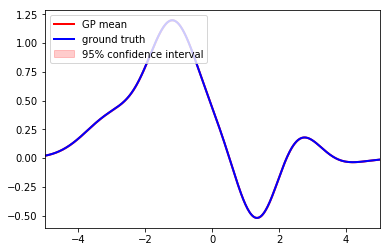

Mean: 0.3543228994961702 , Variance 0.0000001118812551
ITERATION: 22


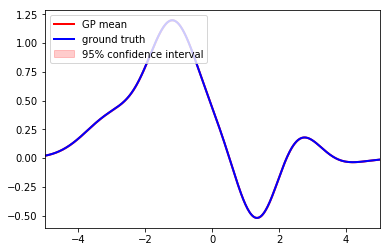

Mean: 0.3543230131786893 , Variance 0.0000000839810941
ITERATION: 23


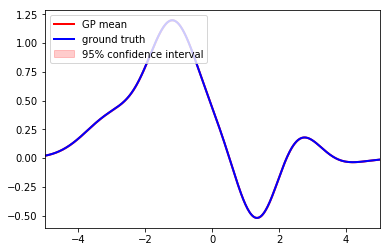

Mean: 0.3543230333234013 , Variance 0.0000000731785014
ITERATION: 24


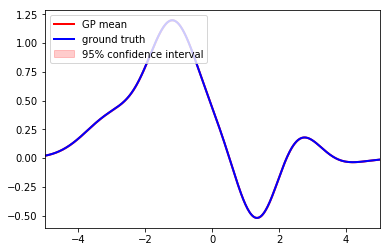

Mean: 0.3543230397898303 , Variance 0.0000000564069381
ITERATION: 25


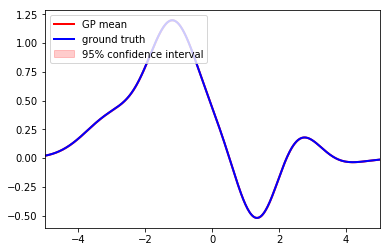

Mean: 0.3543230402669648 , Variance 0.0000000482800904
ITERATION: 26


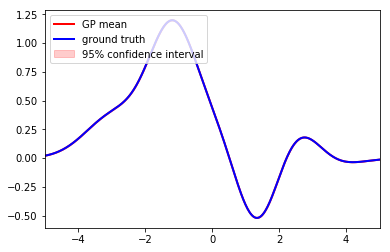

Mean: 0.3543230396047777 , Variance 0.0000000423411484
ITERATION: 27


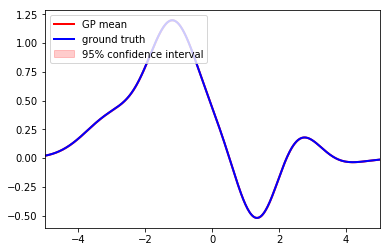

Mean: 0.3543230386819248 , Variance 0.0000000374964297
ITERATION: 28


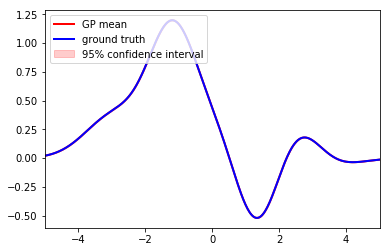

Mean: 0.3543230378287904 , Variance 0.0000000334872750
ITERATION: 29


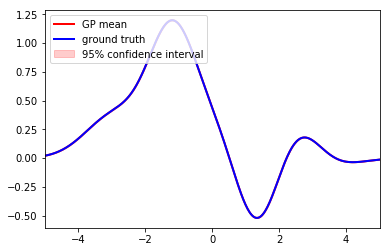

Mean: 0.3543230371501472 , Variance 0.0000000301945013
[(0.35386462121651585, 0.37748185947521856), (0.354145627746215, 0.3769992459412099), (0.1351589349120774, 0.12699940969695211), (0.1389938347630227, 0.12840071286169535), (0.00367656860714366, 0.04164737039213651), (0.007362264886608905, 0.010469232622709879), (0.01465610668055245, 0.001682371131345839), (0.007068613629323539, 0.00018914962874594377), (0.0017922763181020818, 1.5270708407566502e-05), (0.0002724095570350027, 1.2126527426659095e-06), (1.3522851815217507e-05, 4.4495506928976525e-07), (2.3239159479993e-05, 4.2906710429058137e-07), (3.992952041736997e-05, 4.1469817180228574e-07), (4.783213898873484e-05, 3.944812193568126e-07), (1.598122560397819e-05, 3.507659871448965e-07), (2.9311324863834365e-05, 3.1852632081941223e-07), (2.5027869109961465e-06, 2.668746810763345e-07), (9.142415780316604e-06, 2.3662695097792508e-07), (1.4505912343532046e-07, 1.8947942409530683e-07), (1.6008477283224742e-06, 1.6607368252818944e-07), (1

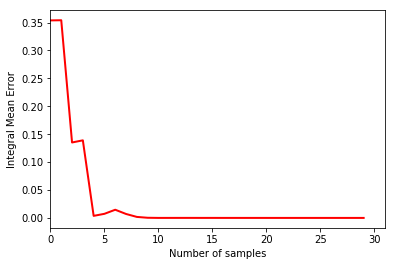

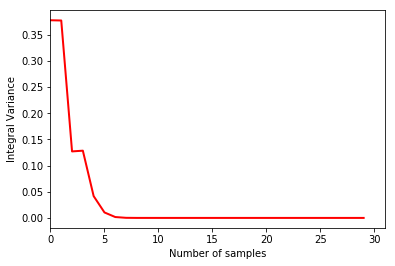

In [6]:
yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    print "ITERATION: %d" % i
    x = np.atleast_2d(np.linspace(-5,5,i+1)).T
    y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')